<a href="https://colab.research.google.com/github/soobook/TensorFlow-DL/blob/main/code/TF16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 16회차: DNN-GAN을 활용한 손글씨 모방하기 (2) - 모델 구현


In [1]:
# -------------------- 1. 라이브러리 로딩 --------------------
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
from tensorflow.keras import layers
from scipy.linalg import sqrtm
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

### MNIST 데이터셋 로드와 데이터 전처리
- GAN 학습에 맞게 전처리: 이미지 [-1, 1] 정규화와 이미지 평탄화(flatten) 작업 수행  
	- GAN의 생성자는 마지막 층의 활성화 함수로 tanh를 사용하므로 이 범위에 맞춤
  - 진짜 이미지도 같은 범위인 [-1, 1]로 정규화 해줘야 판별자(Discriminator)가 올바르게 비교가 가능



In [2]:
# -------------------- 2. 데이터 준비 --------------------
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
print("정규화 전:", x_train.min(), x_train.max())
# [-1, 1]로 정규화
x_train = (x_train.astype("float32") - 127.5) / 127.5  # [-1, 1]

print("정규화 후:", x_train.min(), x_train.max())
print(x_train.shape)
x_train = x_train.reshape((-1, 784))
print(x_train.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
정규화 전: 0 255
정규화 후: -1.0 1.0
(60000, 28, 28)
(60000, 784)


In [3]:
# 시각화 준비
!pip install koreanize_matplotlib
import koreanize_matplotlib
%config InlineBackend.figure_format = 'retina'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 69.6 MB/s eta 0:00:00


### 생성자 마지막 층에서 활성화 함수 tanh()를 사용해 [-1, 1] 이미지를 생성하는 이유
  - 픽셀값이 너무 크거나 작지 않게 “자연스러운 이미지 범위”로 맞춰서 학습 안정성과 출력 품질을 향상
  - 생성자가 만들어 내는 가짜 이미지가 [-1, 1]의 값이므로
  - 진짜 이미지도 같은 범위인 [-1, 1]로 정규화 해줘야 판별자(Discriminator)가 올바르게 비교가 가능

### 함수 tanh()
$$
\tanh(x) = \frac{\sinh(x)}{\cosh(x)} = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}
$$





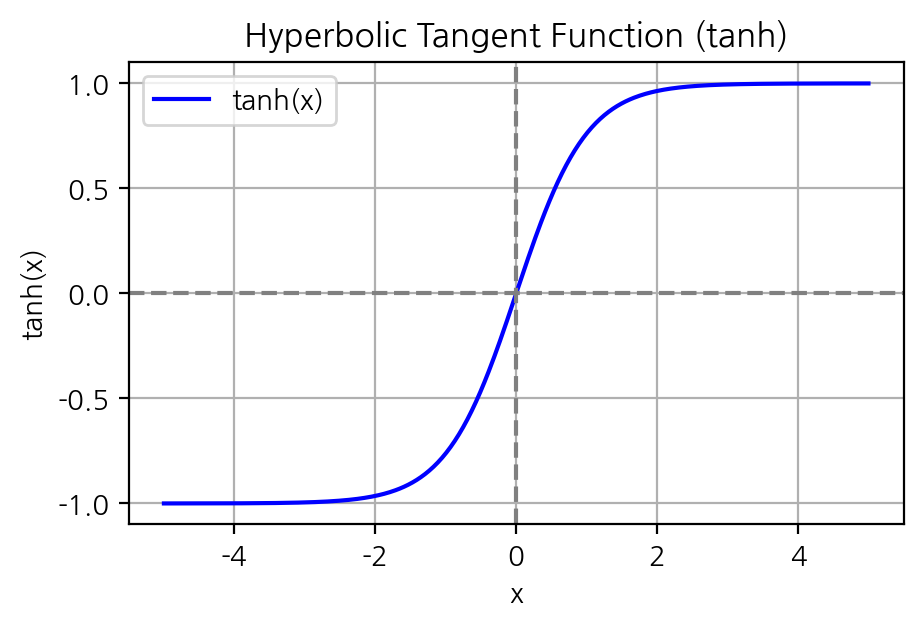

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# 입력 범위 설정: -5 ~ 5 사이 실수값
x = np.linspace(-5, 5, 500)
# tanh 함수 계산
y = np.tanh(x)

# 그래프 그리기
plt.figure(figsize=(5, 3))
plt.plot(x, y, label='tanh(x)', color='blue')
plt.title("Hyperbolic Tangent Function (tanh)")
plt.xlabel("x")
plt.ylabel("tanh(x)")
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.grid(True)
plt.legend()
plt.show()

### GAN 학습을 위한 데이터 준비
- BUFFER_SIZE = 60000: 셔플(무작위 섞기)를 위한 버퍼 크기
  - MNIST 전체 학습 이미지 수(60,000개)와 일치시켜 전체를 완전히 섞음
- BATCH_SIZE = 128: 한 번에 모델에 입력해 가중치를 수정하는 이미지 수
  - 즉, 한 step에서 판별자와 생성자가 학습하는 데이터 양을 정함
  - 너무 작으면 학습이 느리고 불안정, 너무 크면 메모리 부족


In [5]:
BUFFER_SIZE = 60000
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(x_train). \
                shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [7]:
tf.__version__

'2.19.0'

In [10]:
# Dataset 구조 확인
print(train_dataset.element_spec, '\n')

# Dataset에서 배치의 수 확인
count = 0
for _ in train_dataset:
    count += 1
print("총 배치 개수:", count, '\n')

# 첫 번째 배치만 출력
for batch in train_dataset.take(2):
    print("배치 shape:", batch.shape)
    print("배치 일부 데이터:\n", batch[0:5])  # 앞의 5개 데이터만 출력

TensorSpec(shape=(None, 784), dtype=tf.float32, name=None) 

총 배치 개수: 469 

배치 shape: (128, 784)
배치 일부 데이터:
 tf.Tensor(
[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]], shape=(5, 784), dtype=float32)
배치 shape: (128, 784)
배치 일부 데이터:
 tf.Tensor(
[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]], shape=(5, 784), dtype=float32)


### 생성자(Generator) 모델 정의: 노이즈 → 손글씨 이미지 생성
- 입력: 100차원 랜덤 노이즈 벡터 z
- Dense(256) → 중간 은닉층
- Dense(512) → 더 복잡한 구조로 확장
- Dense(784, activation='tanh') → 28×28 이미지를 펼친 벡터 ([-1, 1] 범위 출력)





### 판별자(Discriminator) 모델 정의: 이미지 → 진짜/가짜 판별
- 입력: 784차원 이미지 벡터 (실제든 생성된 것이든)
- Dense(512) → 특징 추출
- Dense(256) → 비선형 판단 강화
- Dense(1, sigmoid) → 최종적으로 “진짜(1)”인지 “가짜(0)”인지 확률 출력

In [ ]:
# -------------------- 3. 모델 정의 --------------------
def make_generator_model():
    return tf.keras.Sequential([
        tf.keras.Input(shape=(100,)), # 명시적 Input layer
        layers.Dense(256, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(784, activation='tanh') # 출력은 784 = 28x28
    ])

def make_discriminator_model():
    return tf.keras.Sequential([
        tf.keras.Input(shape=(784,)), # 명시적 Input layer
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid') # 출력은 실수 하나 (진짜/가짜 확률)
    ])

### 정규 분포(65, 95, 99.7)

| 구간     | 포함되는 비율     | 의미                            |
| ------ | ----------- | ----------------------------- |
| μ ± 1σ | 약 **68%**   | 평균에서 표준편차 1 이내에 전체의 약 68% 데이터 |
| μ ± 2σ | 약 **95%**   | 표준편차 2 이내에 약 95% 데이터          |
| μ ± 3σ | 약 **99.7%** | 표준편차 3 이내에 거의 모든 데이터 포함       |


In [ ]:
# 표준 정규 분포 난수 생성
tf.random.normal([BATCH_SIZE, 100])

<tf.Tensor: shape=(128, 100), dtype=float32, numpy=
array([[-0.11491171,  0.38009262, -0.13110414, ..., -1.3035576 ,
        -0.16940023, -0.73421943],
       [-1.5866891 , -0.77660686, -1.542433  , ..., -1.0679109 ,
        -1.1183635 ,  1.0735601 ],
       [ 0.6984921 , -0.9841736 ,  0.23516668, ..., -0.849656  ,
        -1.4869792 , -0.14337865],
       ...,
       [-0.92857236, -1.575435  , -1.0733782 , ..., -1.614296  ,
         0.4812767 ,  0.24278365],
       [ 0.01280581,  0.34450883,  0.2581041 , ...,  0.491478  ,
        -0.61437553,  0.32791272],
       [-0.21389392,  0.11532076,  0.26230267, ..., -1.0576286 ,
        -1.2353674 ,  1.209835  ]], dtype=float32)>

In [ ]:
# -------------------- 4. GAN 클래스 정의 --------------------
class GAN(tf.keras.Model):
    # Generator와 Discriminator 모델 연결(설정)
    def __init__(self, generator, discriminator):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator

    # Optimizer 및 손실 함수 설정
    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super().compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    # GAN 학습 로직 1 스텝 정의 (Discriminator → Generator 순)
    # 메소드 train_step(): model.fit(...) 내부에서 자동 호출
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0] # 128
        # 생성자에 넣을 입력 노이즈 벡터를 생성해 변수 noze에 저장
        # 하나의 이미지를 될 100차원의 랜덤 벡터
        # batch_size 만큼 생성 → (128, 100) 모양의 2D 텐서가 만들어짐
        # 나중에 생성자는 이 noze로부터 28 x 28인 784차원의 이미지를 생성
        noise = tf.random.normal([batch_size, 100]) # 정규분포 난수, 크기 (128, 100)

        # 판별자 Discriminator
        # ----------- Discriminator 학습 시작 -----------
        # Gradient 추적을 위한 테이프 시작 (자동 미분용)
        with tf.GradientTape() as tape:
            # Generator를 통해 가짜 이미지 생성
            fake_images = self.generator(noise)
            # 진짜 이미지에 대한 판별자 출력값(logits)
            real_logits = self.discriminator(real_images)
            # 가짜 이미지에 대한 판별자 출력값(logits)
            fake_logits = self.discriminator(fake_images)
            # 진짜 이미지를 1로 예측하도록 유도하는 손실,
            # loss_fn(목표값(target), 예측값(logit 또는 output))
            d_loss_real = self.loss_fn(tf.ones_like(real_logits), real_logits)
            # 가짜 이미지를 0으로 예측하도록 유도하는 손실
            d_loss_fake = self.loss_fn(tf.zeros_like(fake_logits), fake_logits)
            # 두 손실의 평균 → 최종 Discriminator 손실
            d_loss = (d_loss_real + d_loss_fake) / 2

        # 손실을 기반으로 Discriminator의 gradient 계산
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # 계산된 gradient로 Discriminator의 파라미터 업데이트
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))
        # ----------- Discriminator 학습 끝 -----------

        # 생성자 Generator
        # ----------- Generator 학습 시작 -----------
        # 새로운 노이즈 벡터 샘플링
        noise = tf.random.normal([batch_size, 100])
        # Generator 훈련을 위한 GradientTape 시작
        with tf.GradientTape() as tape:
            # Generator로부터 가짜 이미지 생성
            fake_images = self.generator(noise)
            # 생성된 이미지에 대해 Discriminator가 내놓은 판별값
            fake_logits = self.discriminator(fake_images)
            # Generator는 Discriminator가 "진짜"라고 믿도록 손실을 계산
            g_loss = self.loss_fn(tf.ones_like(fake_logits), fake_logits)

        # 손실에 대한 Gradient 계산 (Generator 파라미터만)
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        # Generator의 파라미터를 업데이트
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))
        # ----------- Generator 학습 끝 -----------

        return {"d_loss": d_loss, "g_loss": g_loss}

## 종료